In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR     # Support Vector Regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import joblib

state = np.random.RandomState(12345)

In [2]:
df = pd.read_csv(r'D:\StudySpace\Nam4_KyI\cap1_ai_feature\data\updated_nutrition_dataset.csv')

In [3]:
df.head()

,Weight,Height,BMI,Age,Gender,BMIcase,ActivityLevel,Goal,Calories,Protein,Carb,Fat,BMR
0,92.085190,1.760250,29.719488,59,Female,Obese,Moderately Active,Loss Weight,1941,146,194,65,1565.007848
1,61.089124,1.595499,23.997776,25,Female,Overweight,Moderately Active,Loss Weight,1639,123,164,55,1322.077937
2,82.454037,1.816538,24.987499,50,Female,Overweight,Lightly Active,Stay Fit,2130,133,266,59,1548.876812
3,101.713306,1.790696,31.720047,62,Female,Obese,Active,Loss Weight,2298,172,230,77,1665.318345
4,99.609527,1.969726,25.673756,57,Male,Overweight,Sedentary,Stay Fit,2337,146,292,65,1947.173792


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10689 entries, 0 to 10688
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Weight         10689 non-null  float64
 1   Height         10689 non-null  float64
 2   BMI            10689 non-null  float64
 3   Age            10689 non-null  int64  
 4   Gender         10689 non-null  object 
 5   BMIcase        10689 non-null  object 
 6   ActivityLevel  10689 non-null  object 
 7   Goal           10689 non-null  object 
 8   Calories       10689 non-null  int64  
 9   Protein        10689 non-null  int64  
 10  Carb           10689 non-null  int64  
 11  Fat            10689 non-null  int64  
 12  BMR            10689 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 1.1+ MB


In [5]:
print(df.isna().sum())

Weight           0
Height           0
BMI              0
Age              0
Gender           0
BMIcase          0
ActivityLevel    0
Goal             0
Calories         0
Protein          0
Carb             0
Fat              0
BMR              0
dtype: int64


## Exploratary Data Analysis

In [6]:
df.describe()

,Weight,Height,BMI,Age,Calories,Protein,Carb,Fat,BMR
count,10689.000000,10689.000000,10689.000000,10689.000000,10689.000000,10689.000000,10689.000000,10689.000000,10689.000000
mean,73.100122,1.792832,23.236664,41.339695,2267.317055,169.330246,259.217326,61.464964,1596.384165
std,21.161896,0.125787,8.197413,13.750747,511.351492,52.905812,65.404173,11.871218,240.044287
min,50.000000,1.390171,12.753801,18.000000,929.000000,70.000000,93.000000,31.000000,942.445728
25%,55.943683,1.732188,16.766271,29.000000,1920.000000,129.000000,214.000000,54.000000,1448.973735
50%,65.705827,1.805181,20.964623,41.000000,2238.000000,153.000000,263.000000,60.000000,1568.860120
75%,87.360575,1.891355,28.861746,53.000000,2579.000000,208.000000,299.000000,68.000000,1736.848599
max,160.000000,1.990000,78.853402,65.000000,4793.000000,419.000000,599.000000,133.000000,2591.753443


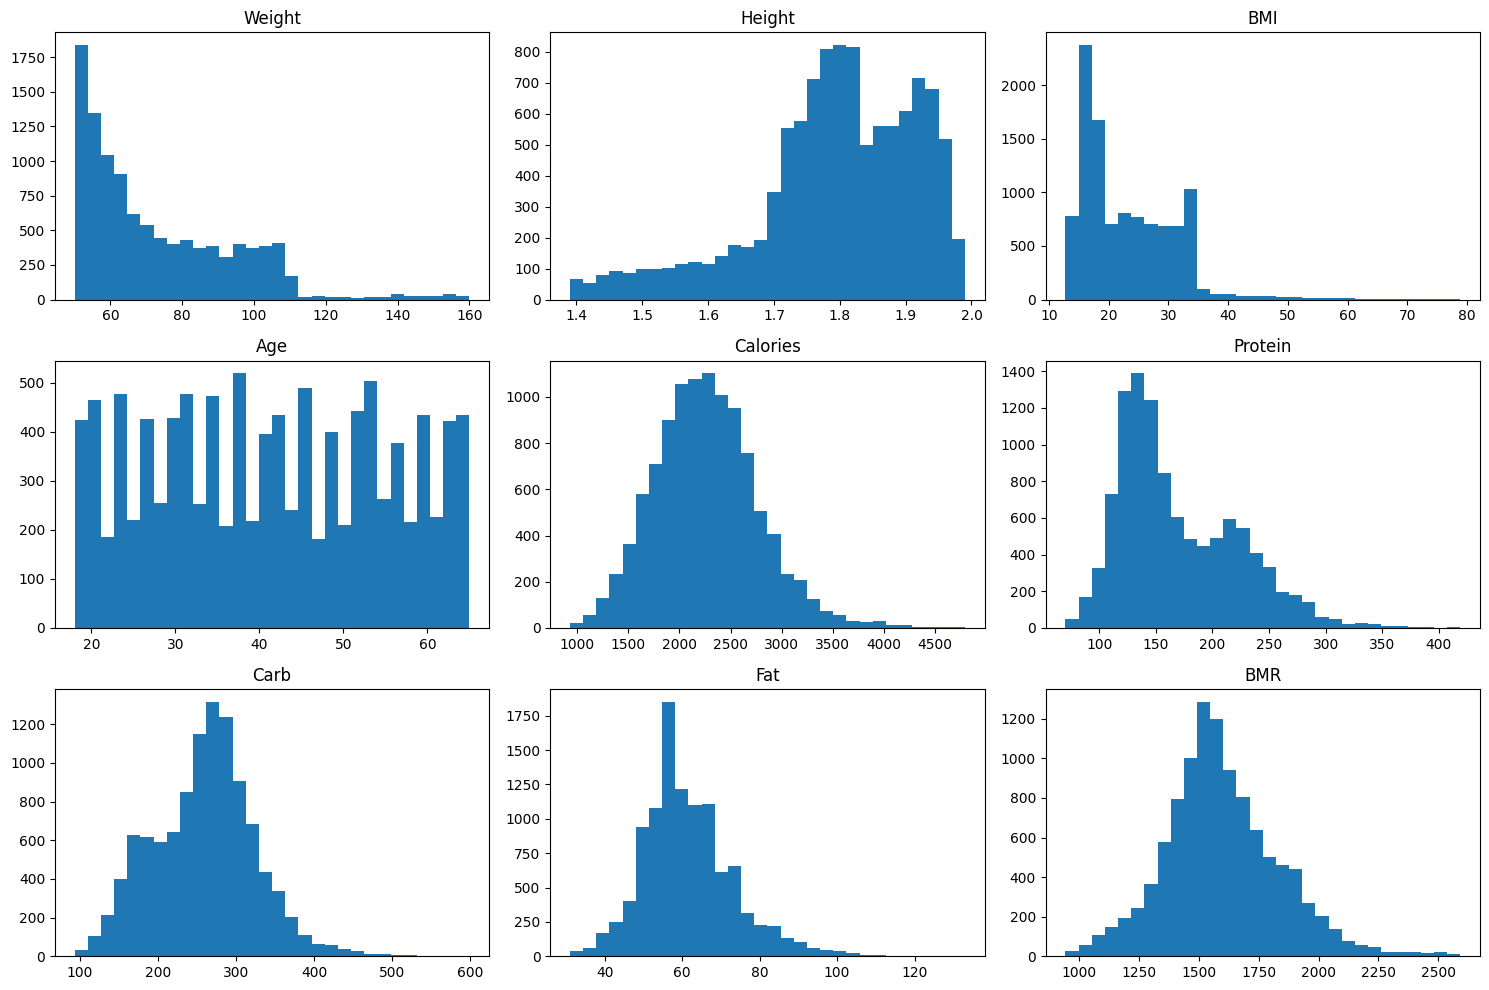

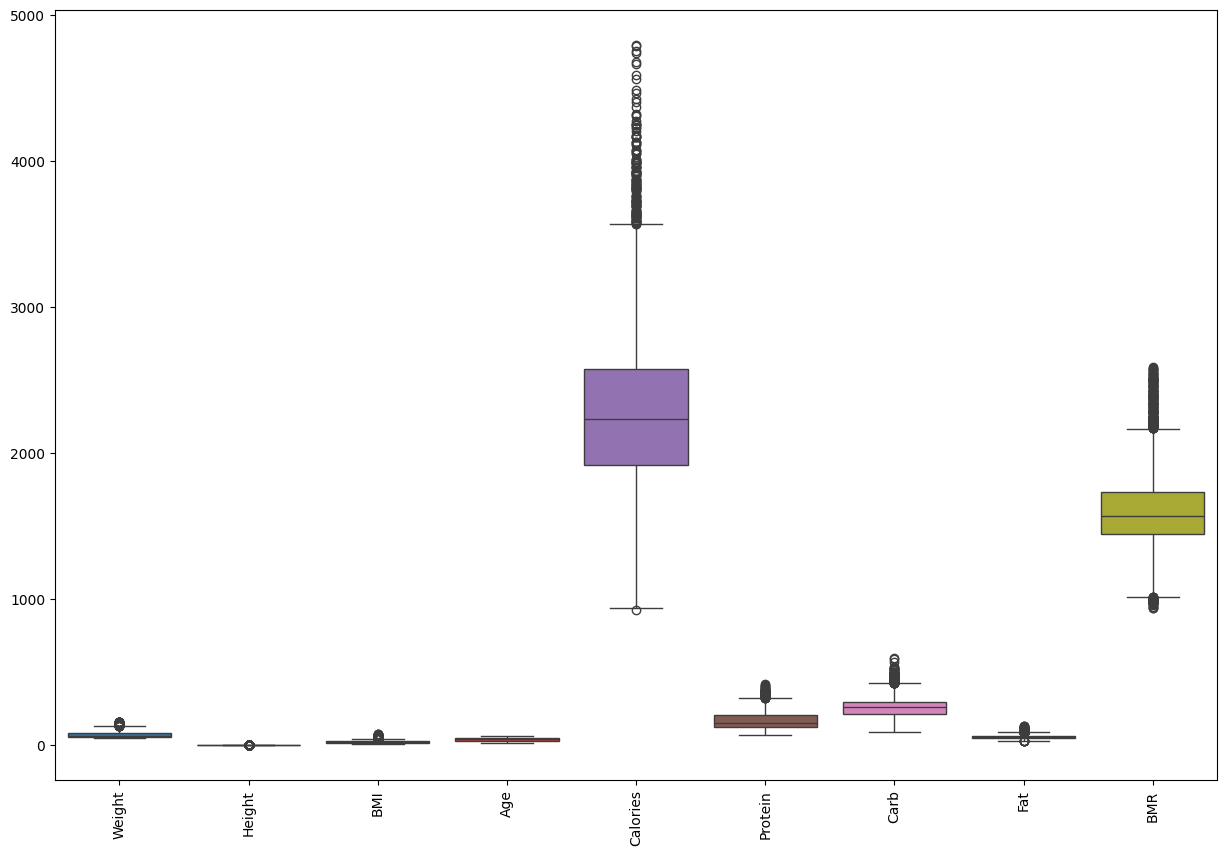

In [7]:
df.hist(bins=30, figsize=(15, 10), grid=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

Index(['Weight', 'Height', 'BMI', 'Age', 'Gender', 'BMIcase', 'ActivityLevel',
       'Goal', 'Calories', 'Protein', 'Carb', 'Fat', 'BMR'],
      dtype='object')


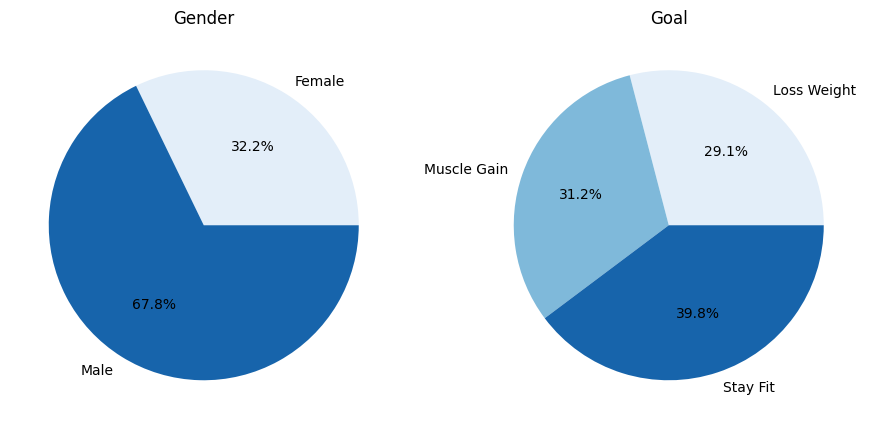

In [8]:
# Check the column names in the dataframe
print(df.columns)

_, axs = plt.subplots(1, 2, figsize=[11,11])
cols = [
    (axs[0], 'Gender'),
    (axs[1], 'Goal'),
]   

cmap = plt.get_cmap('Blues')
for i, (ax, col) in enumerate(cols):
    ax.set(title=col)
    values = df[col].value_counts().sort_index()
    ind = values.index
    colors = list(cmap(np.linspace(0.1, 0.8, len(values))))
    ax.pie(
        values, 
        labels=ind, 
        autopct='%.1f%%', 
        colors=colors
    )
    


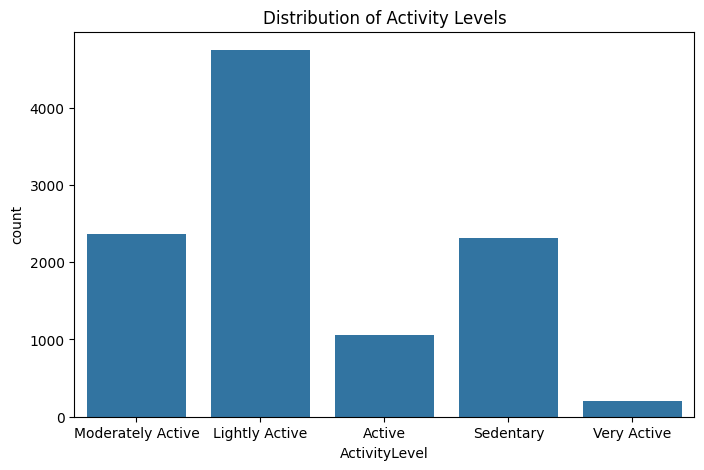

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x="ActivityLevel", data=df)
plt.title("Distribution of Activity Levels")
plt.show()


Relationships between Variables

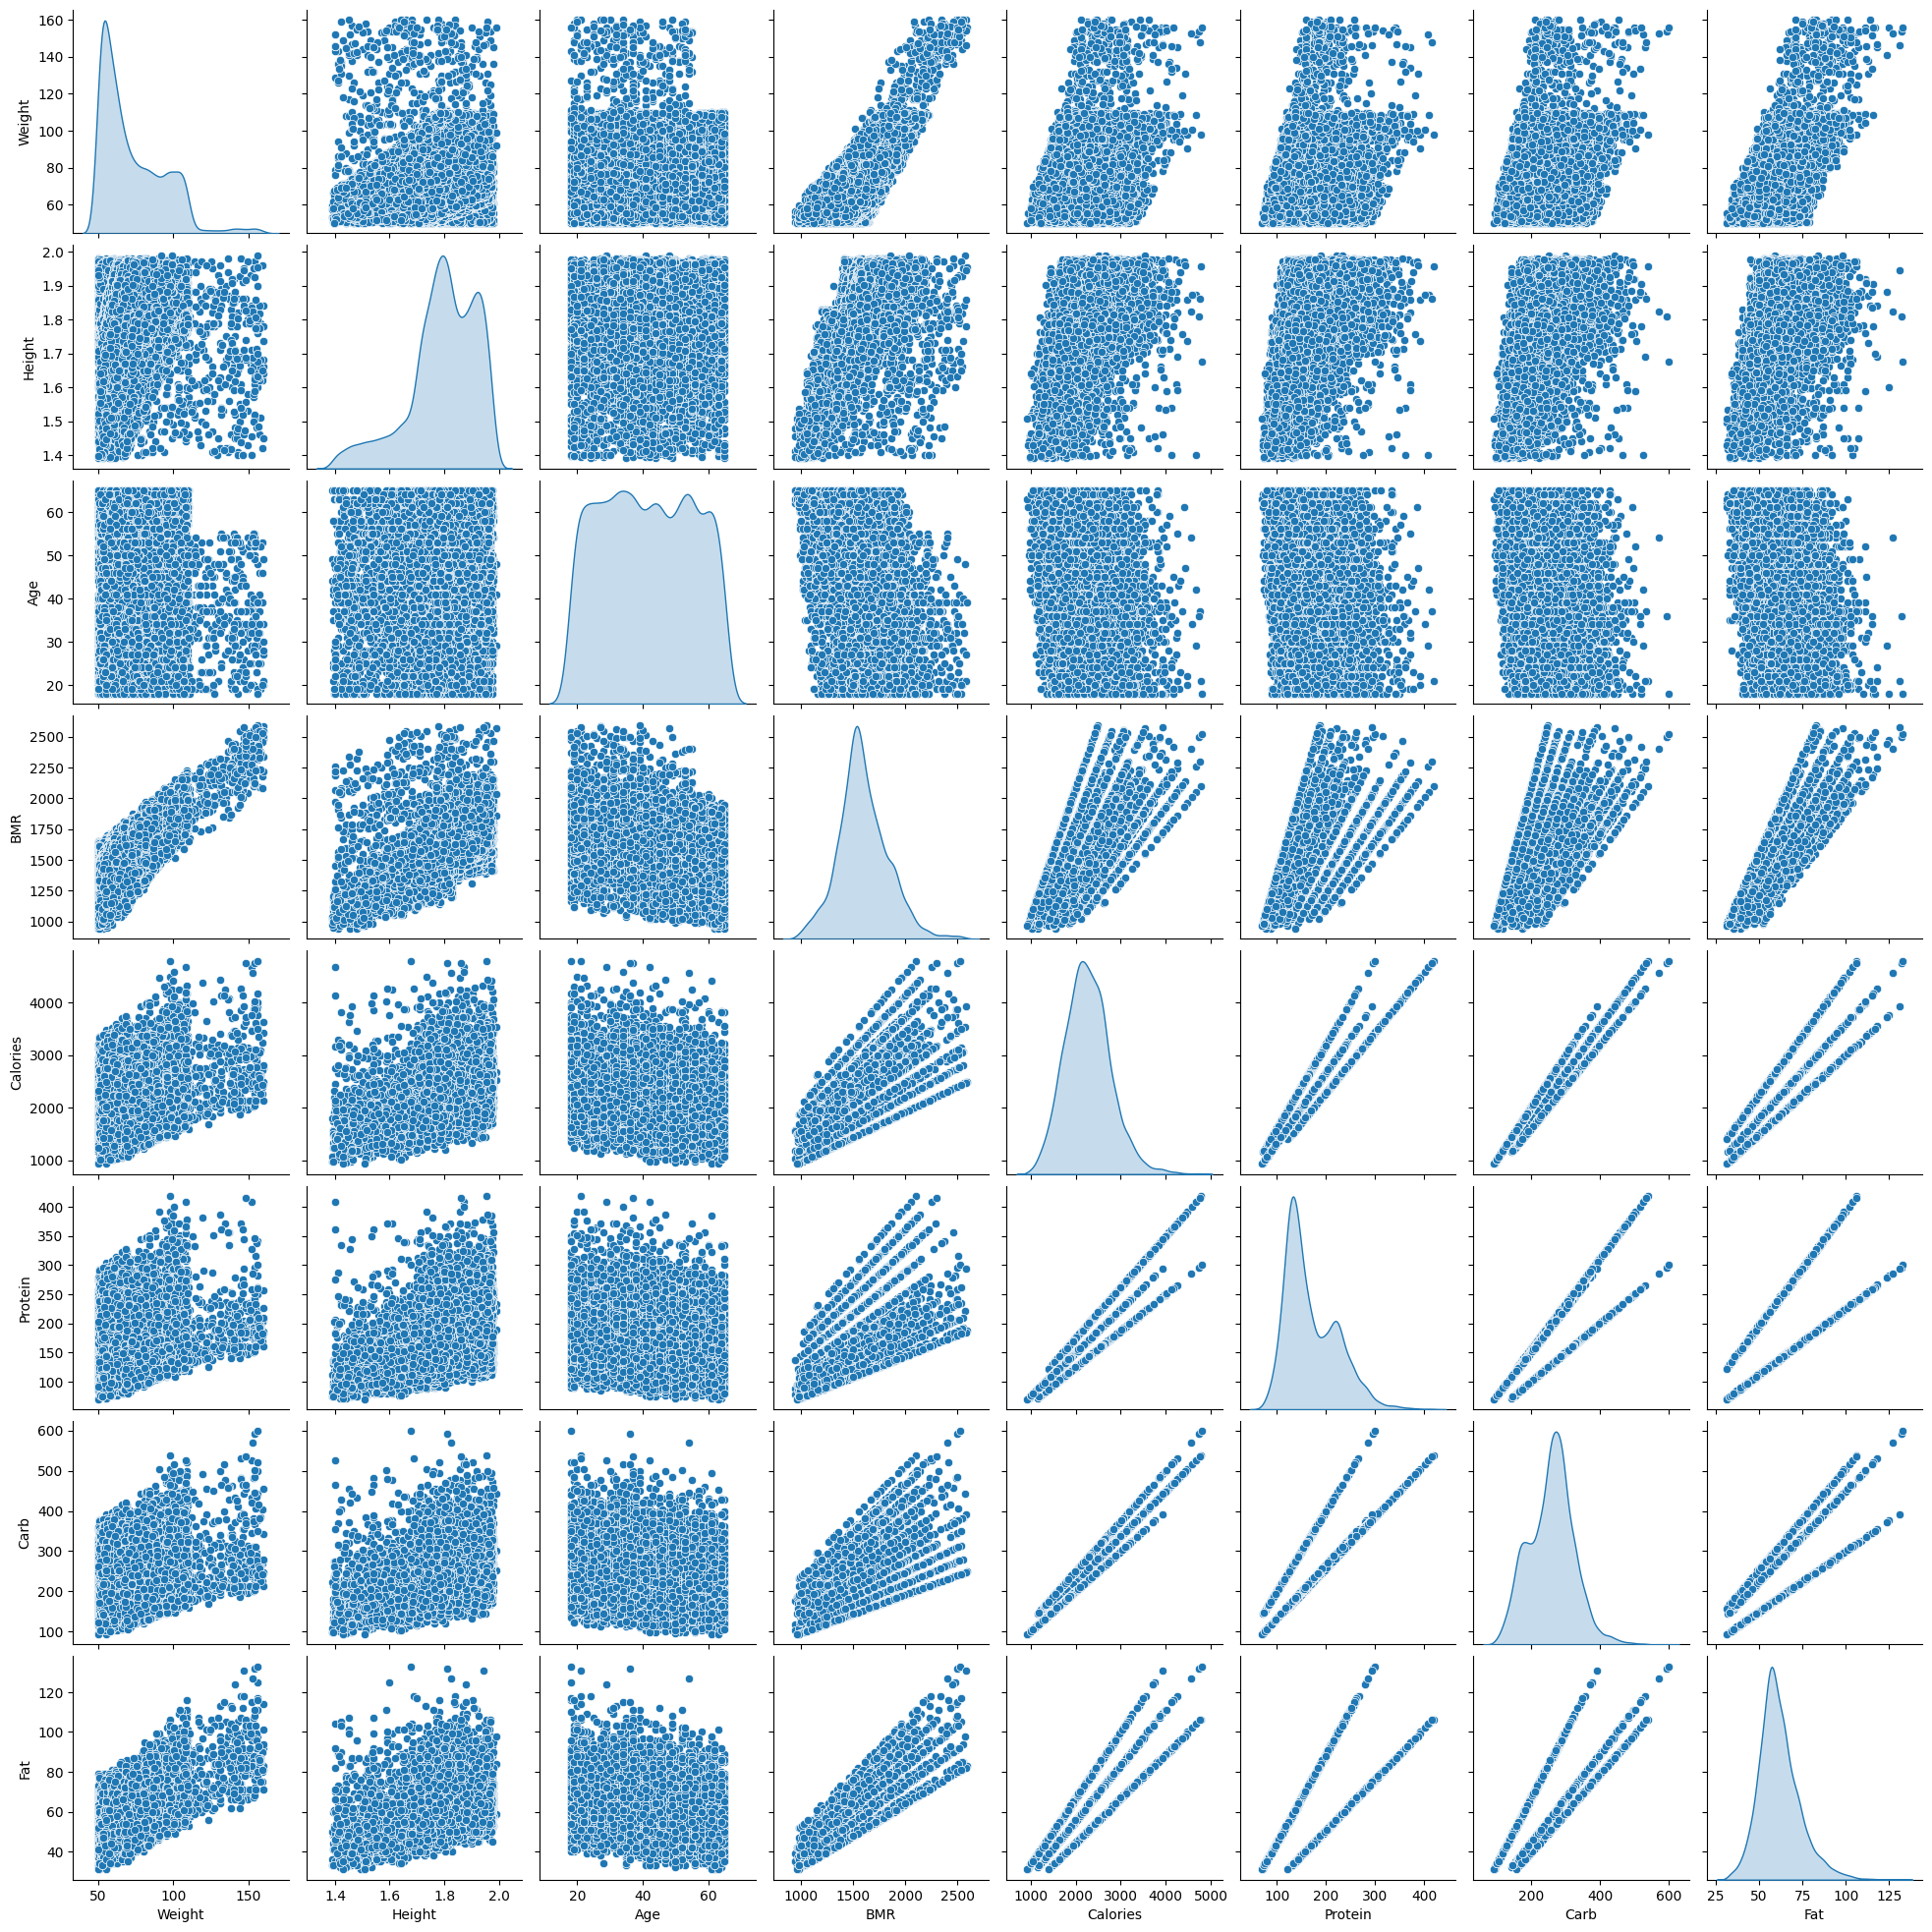

In [10]:
numerical_cols = ["Weight", "Height", "Age", "BMR", "Calories", "Protein", "Carb", "Fat"]
sns.pairplot(df[numerical_cols], diag_kind='kde')
plt.show()

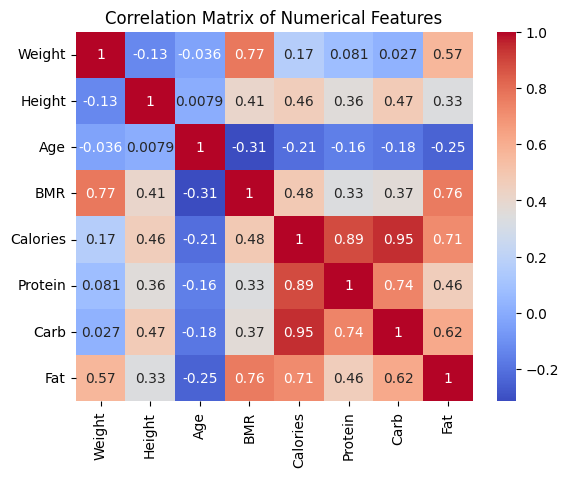

In [11]:
# 5. Correlation Matrix
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Model training

Let's start by clarifying that Macro nutrients are numerical values so actually we are faced with multivariate regression, our task will be solved with the use of regression models. Selected scoring metric will be MSE.

I'll be trying following classification models:
- Linear Regression
- Support Vector Regression
- Random Forest Regression
- Gradient Boosting Regression

In [12]:
cat_features = [
    'Gender',
    'Goal',
    'ActivityLevel', 
]

num_features = [
    'Weight', 
    'Height', 
    'Age', 
]

target = [
    'Calories',
    'Protein',
    'Carb',
    'Fat',
]

X_train, X_test, y_train, y_test = train_test_split(
    df[num_features+cat_features], 
    df[target], 
    test_size=0.2, 
    random_state=state
)

Train selected models in pipeline after OrdinalEncoder and normalization:

In [13]:
# Pipeline stuff
# adding imputer in case future df updates will be with NaNs

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')), # imputer is used to fill missing values
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())  # Or OneHotEncoder(handle_unknown='ignore')
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

### Model Evaluation with Mean Squared Error (MSE)
Four regression models were compared to predict daily calorie and macronutrient needs. We used `Mean Squared Error (MSE)` to evaluate performance with 5-fold cross-validation, prioritizing the model with the lowest average MSE across calories, protein, carbs, and fat. Lower MSE means better accuracy. The results are visualized in a bar plot to aid comparison. This cross-validation approach ensures the chosen model generalizes well to new data.


MSE for Random Forest:
  Calories: 3271.7895
  Protein: 19.0429
  Carb: 45.4362
  Fat: 1.6111

MSE for Gradient Boosting:
  Calories: 3942.1385
  Protein: 34.6723
  Carb: 46.4981
  Fat: 1.5765

MSE for Linear Regression:
  Calories: 147104.3808
  Protein: 2106.7162
  Carb: 1856.3961
  Fat: 48.9858

MSE for Support Vector Regression:
  Calories: 183236.8522
  Protein: 1286.4956
  Carb: 1659.6521
  Fat: 50.1329


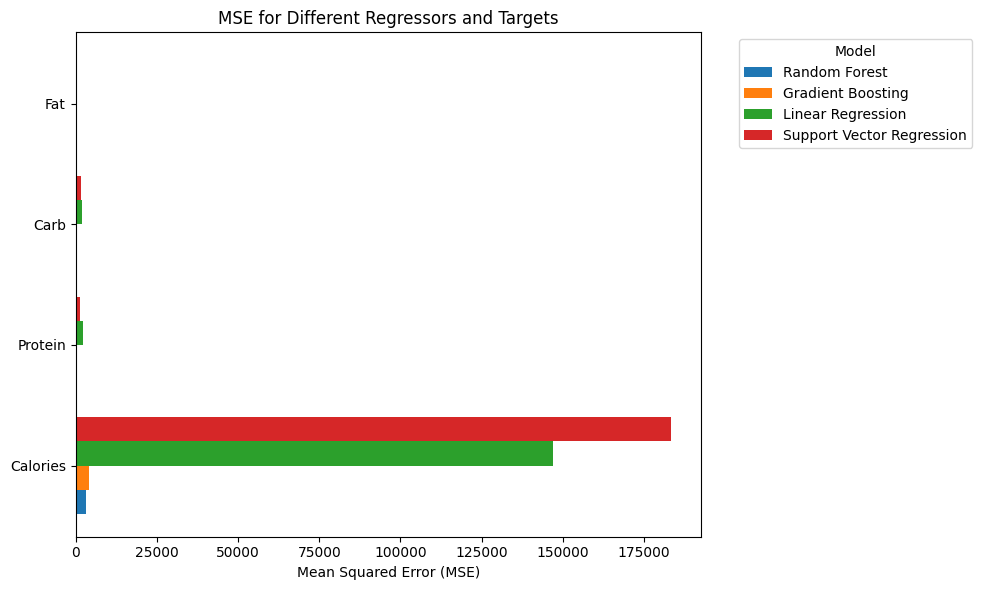

In [ ]:
regressors = {
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Linear Regression": LinearRegression(),
    "Support Vector Regression": SVR()
}

# Train and evaluate for each regressor
results = {}
for name, reg in regressors.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('reg', MultiOutputRegressor(reg))
    ])

    # Predict using cross-validation and evaluate the performance
    y_pred = cross_val_predict(pipeline, X_train, y_train, cv=5)
    
    mse_scores = {}
    for i, target_name in enumerate(y_train.columns):
        mse_scores[target_name] = mean_squared_error(y_train[target_name], y_pred[:, i])
    
    results[name] = mse_scores

# Print the results for each regressor and target
for name, mse_scores in results.items():
    print(f"\nMSE for {name}:")
    for target, mse in mse_scores.items():
        print(f"  {target}: {mse:.4f}")


targets = y_train.columns
model_names = list(results.keys())

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.2
positions = np.arange(len(targets))

# Create a bar plot for each model
for i, model_name in enumerate(model_names):
    mse_values = [results[model_name][target] for target in targets]
    ax.barh(positions + i * width, mse_values, height=width, label=model_name)

ax.set_yticks(np.arange(len(targets)) + width * (len(model_names) - 1) / 2)
ax.set_yticklabels(targets)
ax.set_xlabel('Mean Squared Error (MSE)')
ax.set_title('MSE for Different Regressors and Targets')
ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning (with Random Forest)
As we can see `RandomForestRegressor` has lowest MSE. Now it's time to tune it. I will be tuning in two steps, starting with `RandomSearchCV` and then getting best parameters possible with `GridSearchCV`.

In [37]:
# initialize the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', RandomForestRegressor(random_state=state))
])

max_features = ['sqrt', 'log2', None]
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 15)]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 15)]
bootstrap = [True, False] 

param_dist = {
    'reg__max_features': max_features,
    'reg__n_estimators': n_estimators,
    'reg__max_depth': max_depth,
    'reg__min_samples_split': min_samples_split,
    'reg__min_samples_leaf': min_samples_leaf,
    'reg__bootstrap': bootstrap
}

random_cv = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    cv=5,
    n_iter=200,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    random_state=state
)

random_cv.fit(X_train, y_train)

print('\nBest params:')
print(random_cv.best_params_)
print('\nBest score:', random_cv.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

Best params:
{'reg__n_estimators': 175, 'reg__min_samples_split': 5, 'reg__min_samples_leaf': 2, 'reg__max_features': None, 'reg__max_depth': 11, 'reg__bootstrap': True}

Best score: -1243.5214765871963


Define a refined hyperparameter grid for GridSearchCV based on RandomSearch results

In [38]:
# best_params_from_rs = {
#     'reg__n_estimators': 175, 
#     'reg__min_samples_split': 5, 
#     'reg__min_samples_leaf': 2, 
#     'reg__max_features': None, 
#     'reg__max_depth': 11, 
#     'reg__bootstrap': True
# }

n_estimators = range(150, 201, 25) 
max_depth = range(9, 14,2)      
min_samples_split = range(3, 8, 2) 
min_samples_leaf = range(2, 5, 2)  
max_features = [None, 'sqrt', 'log2']          
bootstrap = [True, False]             

param_grid = {
    'reg__max_features': max_features,
    'reg__n_estimators': n_estimators,
    'reg__max_depth': max_depth,
    'reg__min_samples_split': min_samples_split,
    'reg__min_samples_leaf': min_samples_leaf,
    'reg__bootstrap': bootstrap
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

print("Best parameters from GridSearchCV:")
print(grid_search.best_params_)
print("Best MSE from GridSearchCV:", grid_search.best_score_)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


d:\StudySpace\Nam4_KyI\cap1_ai_feature\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from GridSearchCV:
{'reg__bootstrap': True, 'reg__max_depth': 13, 'reg__max_features': None, 'reg__min_samples_leaf': 2, 'reg__min_samples_split': 3, 'reg__n_estimators': 200}
Best MSE from GridSearchCV: -973.4179932580164


Evaluate the best model on the test set

In [ ]:
best_params = grid_search.best_params_

pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics for regression
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)

print("Test RMSE:", rmse)
print("Test R-squared:", r2)
print("Test MAE:", mae)

# evaluation metrics for each target variable individually
for i, target in enumerate(y_test.columns):
    target_rmse = root_mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    target_r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    target_mae = mean_absolute_error(y_test.iloc[:,i],y_pred[:,i])
    print(f"\nMetrics for {target}:")
    print(f"  RMSE: {target_rmse:.4f}")
    print(f"  R-squared: {target_r2:.4f}")
    print(f"  MAE: {target_mae:.4f}")

Test RMSE: 16.690215238974982
Test R-squared: 0.9890850068142736
Test MAE: 9.520382270413487

Metrics for Calories:
  RMSE: 54.7706
  R-squared: 0.9883
  MAE: 31.2762

Metrics for Protein:
  RMSE: 4.2251
  R-squared: 0.9935
  MAE: 2.3511

Metrics for Carb:
  RMSE: 6.2631
  R-squared: 0.9906
  MAE: 3.5586

Metrics for Fat:
  RMSE: 1.5020
  R-squared: 0.9839
  MAE: 0.8957


In [43]:
model_filename = 'random_forest_regressor.pkl'
joblib.dump(pipeline, model_filename)
print(f"Model saved as {model_filename}")

# Load the model
# loaded_model = joblib.load(model_filename)

Model saved as random_forest_regressor.pkl


In [44]:
# Load the model
loaded_model = joblib.load(model_filename)

print(loaded_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Weight', 'Height', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Gender', 'Goal',
                       

## Test on new data

In [45]:
model_filename = "random_forest_regressor.pkl" 
loaded_model = joblib.load(model_filename)

new_data_samples = {
    'Weight': [60, 65, 80, 80, 50],                      
    'Height': [1.72, 1.60, 1.80, 1.55, 1.60],                  
    'Age': [23, 21, 22, 22, 19],
    'Gender': ['Male', 'Female', 'Male', 'Female', 'Female'], 
    'Goal': ['Stay Fit', 'Stay Fit', 'Loss Weight', 'Loss Weight', 'Muscle Gain'],
    'ActivityLevel':['Moderately Active', 'Moderately Active', 'Lightly Active', 'Lightly Active', 'Sedentary'],                        
}

new_data = pd.DataFrame(new_data_samples)
predictions = loaded_model.predict(new_data)

print("Predictions:", predictions)

Predictions: [[2378.82804882  148.732105    297.47354016   66.07928008]
 [2088.90162751  130.54040645  261.16815412   58.09212526]
 [1985.18431257  148.83801381  198.47378094   66.27614919]
 [1646.87519444  123.4594127   164.68440079   54.83264881]
 [1854.22080556  162.29550992  208.67076587   41.19934127]]
